In [2]:
## Import and data processing

import json

import pandas as pd
import numpy as np


with open('sreality/output.json') as data_file: data = json.load(data_file)    
df = pd.io.json.json_normalize(data)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 30)

df.shape

(981, 14)

In [3]:
df.head(3)

,id,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi
0,2558665052,"Kloboukova, Praha 4 - Chodov",",vytah",False,83,3. podlaží z celkem 6 včetně 1 podzemního,4 290 000 Kč,veryGood,panelova,"Lodžie,Panelová,Částečně vybavený",C,3+1/praha-chodov-kloboukova/2558665052,3+1,osobni
1,2667434332,"Družstevní, Praha 4 - Nusle",,False,43,3. podlaží z celkem 5 včetně 1 podzemního,3 990 000 Kč,afterRec,cihlova,"Po rekonstrukci,Lodžie,Vybavený",C,2+kk/praha-nusle-druzstevni/2667434332,2+kk,osobni
2,3520147804,"Menclova, Praha 8 - Libeň","balkon,vytah",False,NaN,NaN,6 321 430 Kč,NaN,ostatni,Ve výstavbě,No,2+kk/praha-liben-menclova/3520147804,2+kk,osobni


In [4]:
df.index = df['id'].apply(pd.to_numeric)
del df['id']


In [5]:
# Column names:
df.columns

Index([u'location', u'navic', u'novostavba', u'plocha', u'podlazi', u'price',
       u'stavOb', u'stavba', u'stitky', u'trida', u'url', u'velikost',
       u'vlastnictvi'],
      dtype='object')

In [6]:
df['location'].value_counts()[:5]

Štolcova, Praha 4 - Modřany           18
Kolbenova, Praha 9 - Vysočany         17
Rohanské nábřeží, Praha 8 - Karlín    13
Voctářova, Praha - Praha 8            12
Libeňský ostrov, Praha 8 - Libeň       9
Name: location, dtype: int64

In [7]:
df['vlastnictvi'].value_counts()

osobni           894
druzstevni        85
statni-obecni      2
Name: vlastnictvi, dtype: int64

In [8]:
df[df['price'] == u'Info o ceně u RK'][:3]

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi
id,,,,,,,,,,,,,
3466731868,"Na Výrovně, Praha 5 - Stodůlky",",garaz,vytah",False,45,4. podlaží z celkem 5,Info o ceně u RK,veryGood,ostatni,"Balkon,Garáž,Vybavený",G,2+kk/praha-stodulky-na-vyrovne/3466731868,2+kk,osobni
3161796956,"Ke Kamýku, Praha - Kamýk",lodzie,True,106,2. podlaží z celkem 3,Info o ceně u RK,Novostavba,cihlova,,B,3+kk/praha-kamyk-ke-kamyku/3161796956,3+kk,osobni
80159068,"Jílovská, Praha - Praha 4",lodzie,False,64,10. podlaží z celkem 11,Info o ceně u RK,afterRec,panelova,"Po rekonstrukci,Panelová",No,3+1/praha-praha-4-jilovska/80159068,3+1,osobni


In [9]:
# Removing our 'priceless' offers
df = df[df['price'] != u'Info o ceně u RK']

In [10]:
df['price'] = df['price'].map(lambda x: x[:x.find(u' Kč')].replace(' ',''))

In [11]:
# converting price to int64
df['price'] = pd.to_numeric(df['price'], errors='coerce')

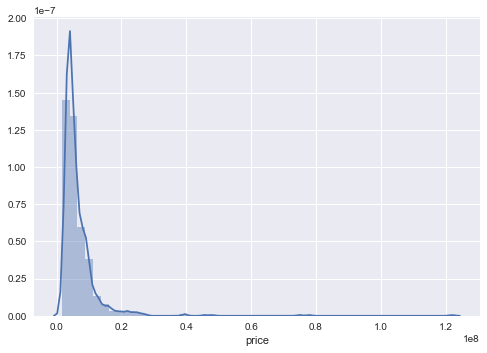

In [12]:
%matplotlib inline
import seaborn as sns
# price destribution
sns.distplot(df['price']);

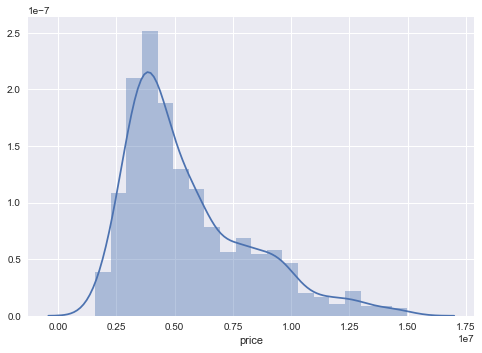

In [13]:
df = df[df['price'] < 15000000]
df = df[df['price'] > 1500000]
sns.distplot(df['price']);

In [14]:
# overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 2558665052 to 3837731164
Data columns (total 13 columns):
location       896 non-null object
navic          896 non-null object
novostavba     896 non-null object
plocha         743 non-null object
podlazi        743 non-null object
price          896 non-null int64
stavOb         856 non-null object
stavba         896 non-null object
stitky         896 non-null object
trida          896 non-null object
url            896 non-null object
velikost       896 non-null object
vlastnictvi    896 non-null object
dtypes: int64(1), object(12)
memory usage: 98.0+ KB


## Filling missing fields

### Užitná plocha

In [15]:
df['plocha'] = pd.to_numeric(df['plocha'], errors='coerce')

In [16]:
df[u'stavOb'].value_counts()

Novostavba    294
veryGood      280
good          134
afterRec      116
beforeRec      32
Name: stavOb, dtype: int64

### Lodžie, Novostavba, sklep, parkovani

In [17]:
def contains_converter(mapping, param):
    for i in mapping:        
        if param.find(i) > -1:
            return mapping[i]
    return ''
balcony_mapping = {
        u'balkon':u'balkon',
        u'lodzie':u'lodzie',
        u'terasa':u'terasa'    
    }

df['sklep'] = df['navic'].str.contains('sklep')
df['parkovani'] = df['navic'].str.contains('parkovani')
df['vytah'] = df['navic'].str.contains('vytah')
df['balkon'] = df['navic'].map(lambda x: contains_converter(balcony_mapping, x))
df.head(3)

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi,sklep,parkovani,vytah,balkon
id,,,,,,,,,,,,,,,,,
2558665052,"Kloboukova, Praha 4 - Chodov",",vytah",False,83.0,3. podlaží z celkem 6 včetně 1 podzemního,4290000,veryGood,panelova,"Lodžie,Panelová,Částečně vybavený",C,3+1/praha-chodov-kloboukova/2558665052,3+1,osobni,False,False,True,
2667434332,"Družstevní, Praha 4 - Nusle",,False,43.0,3. podlaží z celkem 5 včetně 1 podzemního,3990000,afterRec,cihlova,"Po rekonstrukci,Lodžie,Vybavený",C,2+kk/praha-nusle-druzstevni/2667434332,2+kk,osobni,False,False,False,
3520147804,"Menclova, Praha 8 - Libeň","balkon,vytah",False,NaN,NaN,6321430,NaN,ostatni,Ve výstavbě,No,2+kk/praha-liben-menclova/3520147804,2+kk,osobni,False,False,True,balkon


### metro and public transport

In [18]:
df = df.dropna(axis=0, how='any')
df.isnull().any()

location       False
navic          False
novostavba     False
plocha         False
podlazi        False
price          False
stavOb         False
stavba         False
stitky         False
trida          False
url            False
velikost       False
vlastnictvi    False
sklep          False
parkovani      False
vytah          False
balkon         False
dtype: bool

In [19]:
df['floor'] = df['podlazi'].map(lambda x: x[:x.find(u'. podlaží z celkem ')].replace(' ',''))
df['firstFloor'] = df['floor'].map(lambda x: True if x == '1' else False)
df.describe()

,plocha,price
count,718.000000,7.180000e+02
mean,83.665738,5.406215e+06
std,143.653512,2.573762e+06
min,21.000000,1.590000e+06
25%,53.250000,3.590000e+06
50%,69.000000,4.550000e+06
75%,87.000000,6.695000e+06
max,2918.000000,1.499000e+07


In [20]:
df.info()
df.to_csv('priceRaw.csv', encoding = 'utf-8')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 2558665052 to 3837731164
Data columns (total 19 columns):
location       718 non-null object
navic          718 non-null object
novostavba     718 non-null object
plocha         718 non-null float64
podlazi        718 non-null object
price          718 non-null int64
stavOb         718 non-null object
stavba         718 non-null object
stitky         718 non-null object
trida          718 non-null object
url            718 non-null object
velikost       718 non-null object
vlastnictvi    718 non-null object
sklep          718 non-null bool
parkovani      718 non-null bool
vytah          718 non-null bool
balkon         718 non-null object
floor          718 non-null object
firstFloor     718 non-null bool
dtypes: bool(4), float64(1), int64(1), object(13)
memory usage: 92.6+ KB


## Model training

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)

    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

In [22]:
X = df.drop({'price','navic','stitky','url','podlazi'}, axis=1)
Y = df['price']

def encode_all(X1):
    novostavba_le_converter = encode_with_LabelEncoder(X1,'novostavba')
    X1, balcony_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'balkon')
    X1, stavba_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'stavba')
    X1, velikost_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'velikost')
    X1, vlastnictvi_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'vlastnictvi')
    X1, location_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'location')
    X1, stav_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'stavOb')
    X1, floor_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'floor')
    X1, floor_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'trida')
    sklep_le_encoder = encode_with_LabelEncoder(X1,'sklep')
    parkovani_le_encoder = encode_with_LabelEncoder(X1,'parkovani')
    vytah_le_encoder = encode_with_LabelEncoder(X1,'vytah')
    firstFloor_le_encoder = encode_with_LabelEncoder(X1,'firstFloor')
    return X1

X = encode_all(X)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import KFold
from sklearn.model_selection  import cross_val_score
n_folds = 7
records_count = Y.count()
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

In [24]:
%%time
from sklearn.model_selection import GridSearchCV
scores = list()
scores_std = list()


def determine_forest_quality(trees_count):
    clf = RandomForestRegressor(n_estimators = trees_count, random_state=1)
    score = cross_val_score(clf, X, Y, scoring='r2', cv=kf)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))
    return score.mean()

for k in range(1,62,5):
    quality = determine_forest_quality(k)    
    print (k, quality)
    

(1, 0.5178086656327483)
(6, 0.66829186871407165)
(11, 0.69328235662498205)
(16, 0.69666780125792793)
(21, 0.70328524913333879)
(26, 0.70338613853965803)
(31, 0.7095809272442084)
(36, 0.71356360436130584)
(41, 0.71343592590939886)
(46, 0.71403326440761816)
(51, 0.71467307237161293)
(56, 0.71544090510352654)
(61, 0.71610312028080514)
CPU times: user 37.6 s, sys: 268 ms, total: 37.8 s
Wall time: 37.9 s


(0.10000000000000001, 0.31622776601683794)

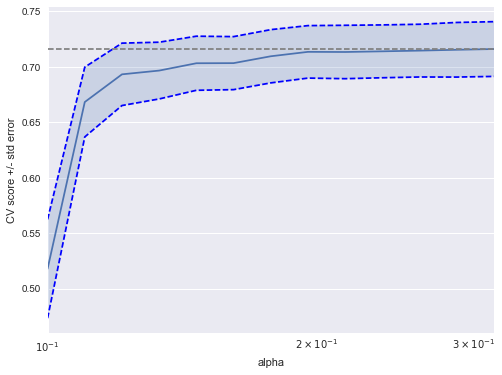

In [25]:
import matplotlib.pyplot as plt
scores, scores_std = np.array(scores), np.array(scores_std)
alphas = np.logspace(-1, -0.5, 13)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [26]:
clf = RandomForestRegressor(n_estimators = 51, random_state=1)
clf.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=51, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [27]:
# top 20 features:
features = X.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for i in range(num_to_plot):
    print features[feature_indices[i]], round(importances[indices[i]],4)

novostavba_le 0.7132
velikost=1+1 0.0573
location=Národní obrany, Praha 6 - Bubeneč 0.0105
location=K Červenému dvoru, Praha 3 - Strašnice 0.0091
location=Jeronýmova, Praha 3 - Žižkov 0.0086
location=Spinozova, Praha - Modřany 0.0074
location=Irská, Praha 6 - Vokovice 0.0071
location=Libická, Praha - Vinohrady 0.006
velikost=4+1 0.0054
stavOb=veryGood 0.0053


In [28]:
predictions = pd.Series(clf.predict(X), index=Y.index)
res_info_forest = pd.DataFrame(columns=['Error,%',u'Error,Kč',u'Price,Kč',u'Price,m²', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100
    #if np.abs(rel_error)>15:
    res_info_forest.loc[i] = pd.Series({
            'Error,%':round(rel_error,1),
            u'Error,Kč':'{:,}'.format(int(error)),
            u'Price,Kč':'{:,}'.format(Y[i]),
            u'Price,m²':'{:,}'.format(int(Y[i]/X['plocha'][i])),
            'URL':'{}/{}/'.format(' https://www.sreality.cz/detail/prodej/byt', df['url'][i])
    })
    

In [29]:
%%time
import xgboost as xgb
scores = list()
scores_std = list()
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
def determine_forest_quality(trees_count):
    clf = xgb.XGBRegressor(n_estimators = trees_count, max_depth = n_folds)
    score = cross_val_score(clf, X, Y, scoring='r2', cv=kf)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))
    return score.mean()

for k in range(1,400,50):
    quality = determine_forest_quality(k)    
    print (k, quality)


(1, -3.5707294768910804)
(51, 0.72762120253250284)
(101, 0.73393857131215601)
(151, 0.73618332720533186)
(201, 0.73722818686432245)
(251, 0.73765880537230932)
(301, 0.73778916300635455)
(351, 0.73783871963104253)
CPU times: user 3min 21s, sys: 709 ms, total: 3min 22s
Wall time: 3min 22s


(1.0000000000000001e-05, 0.31622776601683794)

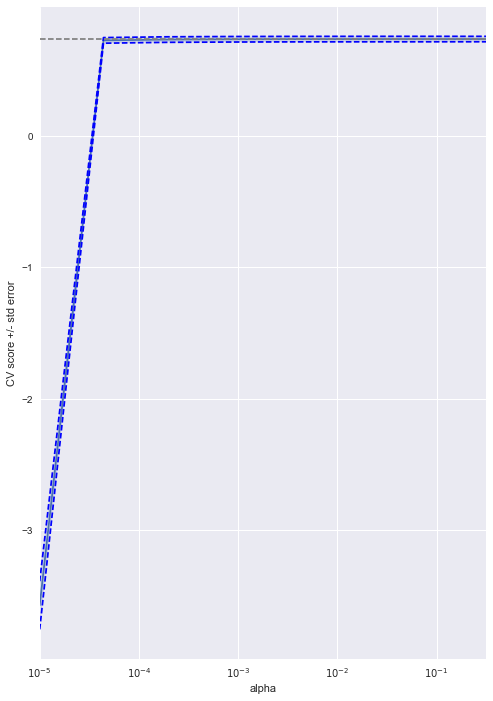

In [30]:
scores, scores_std = np.array(scores), np.array(scores_std)
alphas = np.logspace(-5, -0.5, 8)

plt.figure().set_size_inches(8, 12)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [ ]:
clf = xgb.XGBRegressor(n_estimators = 250, max_depth = n_folds)
clf.fit(X, Y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=350, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Output results

In [ ]:
res_info = pd.DataFrame(columns=['Error,%','Error forest,%',u'Error,Kč',u'Error forest,Kč',u'Price,Kč',u'Price,m²', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100

    #if np.abs(rel_error)>15:
    res_info.loc[i] = pd.Series({
            u'Error,%':round(rel_error,1),
            u'Error forest,%': res_info_forest['Error,%'][i],
            u'Error,Kč':'{:,}'.format(int(error)),
            u'Error forest,Kč': res_info_forest[u'Error,Kč'][i],
            u'Price,Kč':'{:,}'.format(Y[i]),
            u'Price,m²':'{:,}'.format(int(Y[i]/X['plocha'][i])),
            'URL':'{}/{}/'.format(' https://www.sreality.cz/detail/prodej/byt', df['url'][i])
    })
    
# Underpriced offers
pd.options.display.max_colwidth = 100
res_info.sort_values(by=u'Error,%')[:25]

In [ ]:
# Overpriced offers
res_info.sort_values(by='Error,%', ascending=False)[:15]

In [ ]:
predictions[4444]

In [ ]:
res_info.to_csv('priceRes.csv', encoding = 'utf-8', index_label = 'id')